In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

data = pd.read_csv('./dataset.csv')

# 随机排序
data_shuffled = data.sample(frac=1).reset_index(drop=True)

X = data_shuffled[['data1', 'data2']].values
y = data_shuffled['label'].values - 1  # 减1是因为pytorch的loss函数要求类别从0开始

# 10%用于测试，90%用于训练
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape


(torch.Size([3600, 2]),
 torch.Size([3600]),
 torch.Size([400, 2]),
 torch.Size([400]))

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class GaussianClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GaussianClassifier, self).__init__()
        # 第一个隐藏层
        self.fc1 = nn.Linear(input_size, hidden_size)
        # 新增的第二个隐藏层
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # 输出层
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        # 通过第二个隐藏层
        out = self.fc2(out)
        out = self.relu(out)
        # 通过输出层
        out = self.fc3(out)
        return out

# 超参数初始化：2个特征，100个隐藏层神经元，4个类别
input_size = 2  
hidden_size = 100  
num_classes = 4  

# 创建模型实例
model = GaussianClassifier(input_size, hidden_size, num_classes)

model

GaussianClassifier(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=4, bias=True)
  (relu): ReLU()
)

Epoch 1/25, Train Loss: 0.8429, Test Loss: 0.4501, Train Accuracy: 76.86%, Test Accuracy: 90.50%
Epoch 2/25, Train Loss: 0.3405, Test Loss: 0.2319, Train Accuracy: 91.56%, Test Accuracy: 92.00%
Epoch 3/25, Train Loss: 0.2478, Test Loss: 0.1914, Train Accuracy: 92.47%, Test Accuracy: 91.75%
Epoch 4/25, Train Loss: 0.2275, Test Loss: 0.1817, Train Accuracy: 92.69%, Test Accuracy: 92.25%
Epoch 5/25, Train Loss: 0.2232, Test Loss: 0.1841, Train Accuracy: 92.83%, Test Accuracy: 92.50%
Epoch 6/25, Train Loss: 0.2173, Test Loss: 0.1773, Train Accuracy: 92.64%, Test Accuracy: 92.50%
Epoch 7/25, Train Loss: 0.2163, Test Loss: 0.1921, Train Accuracy: 92.86%, Test Accuracy: 92.50%
Epoch 8/25, Train Loss: 0.2131, Test Loss: 0.1799, Train Accuracy: 92.69%, Test Accuracy: 91.50%
Epoch 9/25, Train Loss: 0.2129, Test Loss: 0.1807, Train Accuracy: 92.92%, Test Accuracy: 92.50%
Epoch 10/25, Train Loss: 0.2148, Test Loss: 0.1914, Train Accuracy: 92.78%, Test Accuracy: 92.50%
Epoch 11/25, Train Loss: 0.21

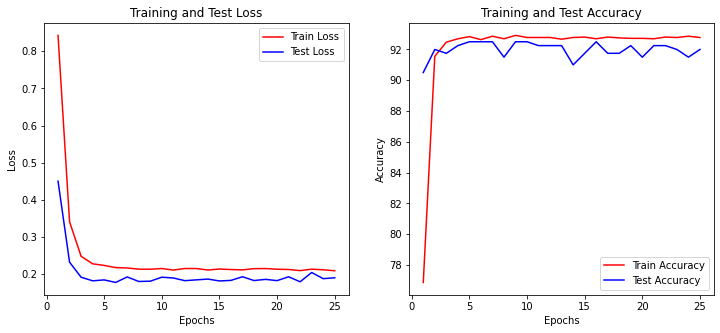

In [3]:
import torch.optim as optim
import matplotlib.pyplot as plt

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss_train = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss_train = running_loss_train / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # 测试阶段
        model.eval()
        running_loss_test = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_test += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_loss_test = running_loss_test / len(test_loader.dataset)
        test_accuracy = 100 * correct_test / total_test

        # 记录损失和准确率
        train_losses.append(epoch_loss_train)
        test_losses.append(epoch_loss_test)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # 打印结果
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss_train:.4f}, Test Loss: {epoch_loss_test:.4f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')
        
    # 绘制Loss和acc曲线
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r-', label='Train Loss')
    plt.plot(epochs, test_losses, 'b-', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'b-', label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 训练
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25)